# Testing fasterrcnn_resnet50_fpn

In [10]:
import os

# Get current notebook directory
current_dir = os.getcwd()

# Move up one level to reach 'A'
project_root = os.path.dirname(current_dir)


In [12]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO


def predicted_image(coco, image_dir, image_id):

    # COCO class labels
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
        'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
        'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    # Load pre-trained Faster R-CNN model
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    # Define image pre-processing transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image_info = coco.loadImgs(image_id)[0]
    image_path = f"{image_dir}/{image_info['file_name']}"

    # Load the image
    image = Image.open(image_path)

    # Pre-process the image
    input_image = transform(image).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        prediction = model(input_image)

    # Extract bounding boxes, labels, and scores from the prediction
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # filter out only specific categories
    target_indices = [i for i, label in enumerate(labels) if label == 1 ]
    filtered_boxes = boxes[target_indices]
    filtered_labels = labels[target_indices]
    filtered_scores = scores[target_indices]

    # Filter out detections based on a confidence threshold
    threshold = 0.8
    filtered_boxes = filtered_boxes[filtered_scores > threshold]
    filtered_labels = filtered_labels[filtered_scores > threshold]
    filtered_scores = filtered_scores[filtered_scores > threshold]

    # Display the detected boxes and labels
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='r', linewidth=2)
        ax.add_patch(rect)
        label_text = f"{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}"
        ax.text(x_min, y_min - 5, label_text, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

    # Print the number of detected objects
    print(f"Detected {len(filtered_boxes)} objects.")


# COCO Instance & Image Example

In [19]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

def get_coco_image(coco,image_dir,image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = f"{image_dir}/{image_info['file_name']}"

    # Load the image
    image = Image.open(image_path)

    # Load ground-truth annotations for the selected image
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

    # Display the image with ground-truth bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    count = 0 
    for annotation in annotations:
        if annotation['category_id'] != 1: 
            continue
        count += 1

        # Extract bounding box (in COCO format: [x_min, y_min, width, height])
        x_min, y_min, width, height = annotation['bbox']
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        # Add class label
        category_id = annotation['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        ax.text(x_min, y_min - 5, category_name, color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    plt.show()

    # Print the number of ground-truth objects
    print(f"Number of ground-truth objects: {count}")


# Display Object Counts

In [40]:
import pandas as pd 

df = pd.read_json("pretrained_fasterrcnn_results.json")
extract_element = lambda x: extract_element(x[0]) if isinstance(x, list) and len(x) == 1 else x

df["ground_truths"] = df["ground_truths"].apply(extract_element)
df["prediction"] = df["prediction"].apply(extract_element)
    
df = df[df["ground_truths"] != df["prediction"]]
# df = df[df["ground_truths"] == 0]

df

,image_id,boxes,labels,scores,prediction,ground_truths
3,[87038],"[[347.9857177734375, 173.61578369140625, 420.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.9992873072624201, 0.9959439635276791, 0.985...",15.0,14.0
7,[480985],"[[318.118408203125, 273.1240539550781, 348.250...","[1, 1, 1, 1, 1]","[0.9981008172035211, 0.97988224029541, 0.96424...",5.0,8.0
10,[296649],"[[1.974040746688842, 266.5019836425781, 106.21...","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.9974176883697511, 0.9965305924415581, 0.992...",9.0,13.0
13,[491497],"[[4.242149353027344, 219.94825744628906, 79.13...",[1],[0.9881200790405271],1.0,0.0
17,[522713],[],[],[],0.0,2.0
...,...,...,...,...,...,...
4989,[478721],"[[325.6462097167969, 231.0423126220703, 393.25...","[1, 1, 1, 1]","[0.9990124702453611, 0.998112678527832, 0.9657...",4.0,5.0
4991,[98287],"[[165.32154846191406, 257.42388916015625, 217....","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.998861908912658, 0.9980092644691461, 0.9944...",9.0,14.0
4997,[552775],"[[1.553009748458862, 141.27005004882812, 107.2...","[1, 1]","[0.947586178779602, 0.897972822189331]",2.0,1.0
4998,[394940],"[[0.22947488725185303, 67.16062927246094, 424....","[1, 1]","[0.993895828723907, 0.8124086260795591]",2.0,1.0


loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


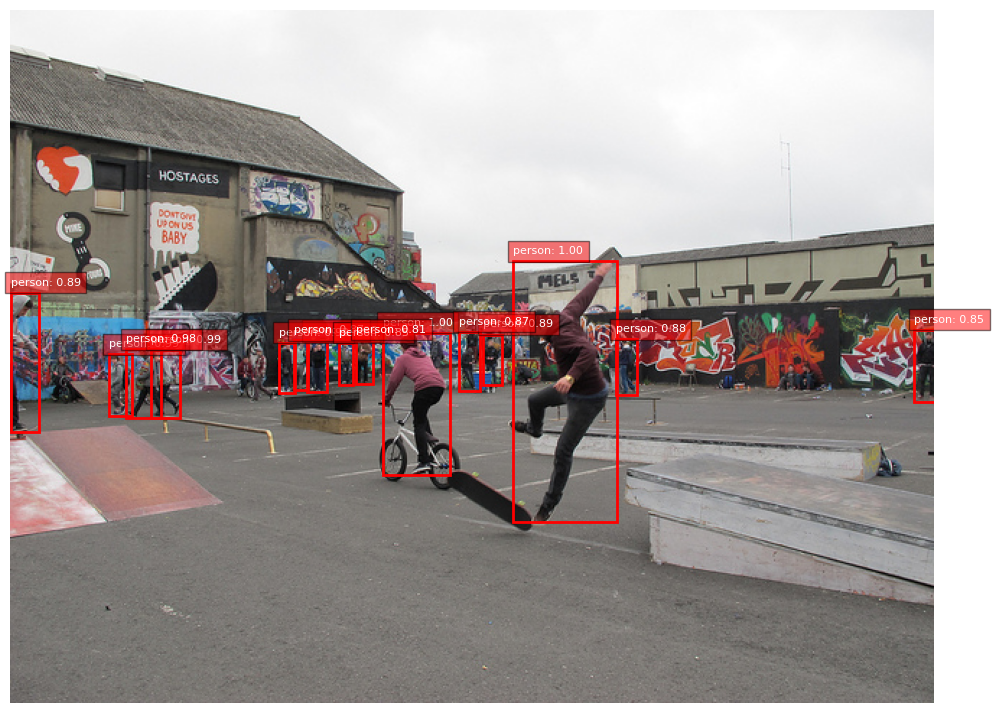

Detected 15 objects.


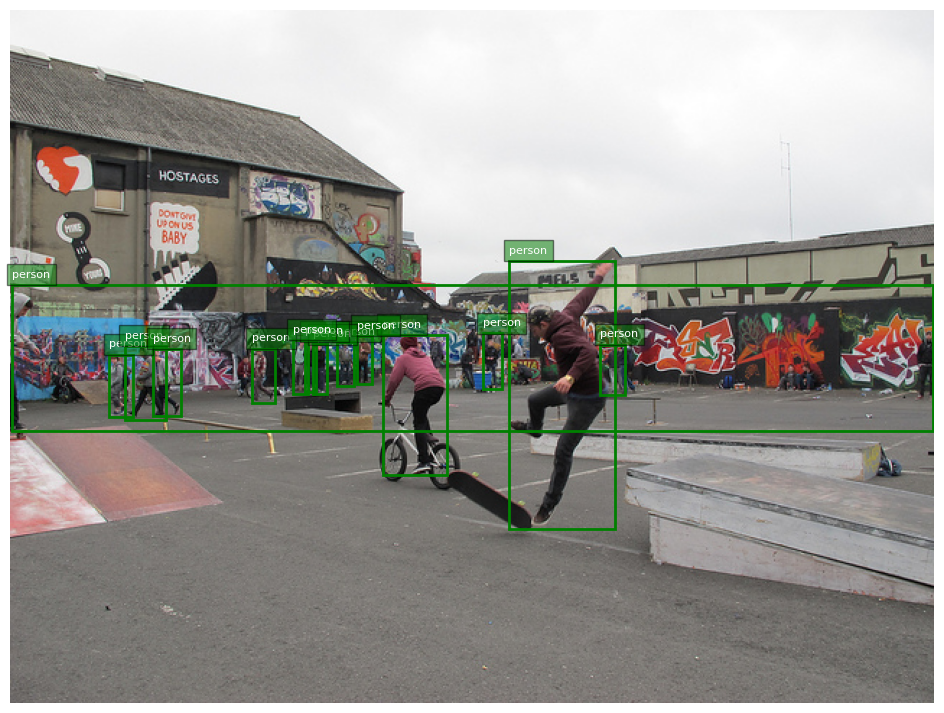

Number of ground-truth objects: 14


In [42]:

image_dir = f'{project_root}/data/COCO/images/val2017/'  # Directory containing COCO images
annotation_file = f'{project_root}/data/COCO/annotations/instances_val2017.json'  # Annotation JSON file

# Load COCO annotations
coco = COCO(annotation_file)

# Select an image by ID or randomly
image_id = 87038  # Example image ID (000000391895.jpg)

image_ids = [87038,491497]

predicted_image(coco,image_dir,image_id)
get_coco_image(coco,image_dir,image_id)